In [13]:
import matplotlib.pyplot as plt
import numpy as np
import rospy

In [103]:
# Set up helper functions
from sensor_msgs.msg import JointState
from std_msgs.msg import Float64MultiArray
import rosbag
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

def bag_loader(path, map_and_append_msg, topic_name = 'robot_state', normalize = ''):
    bag = rosbag.Bag(path)
    num_obs = bag.get_message_count(topic_name)
    if num_obs == 0:
        topic_name = '/'+topic_name
        num_obs = bag.get_message_count(topic_name)
    print('Loading ros bag {}  with {} msgs on topic {}'.format(path, num_obs, topic_name))

    msgs = {}
    t = []
    for _, msg, t_ros in bag.read_messages(topics=[topic_name]):
        t.append(t_ros.to_sec())
        map_and_append_msg(msg, msgs)
    t = [tt-t[0] for tt in t]

    msgs_in_order = {}
    for key in msgs.keys():
        t_in_order, el_in_order = zip(*sorted(zip(t,msgs[key])))
        msgs_in_order[key] = np.array(el_in_order).T
    msgs_in_order['t'] = t_in_order
    
    if normalize != '':
        msgs_in_order[normalize] = (msgs_in_order[normalize].T-msgs_in_order[normlize][:,0]).T
        
    return msgs_in_order

def get_aligned_msgs(msgs1, msgs2):
    ''' 
    Select entries from msgs2 which occured most recently before msgs1
    '''
    aligned_msgs2 = {key:[] for key in msgs2.keys()}
    t2 = np.array(msgs2['t'])
    for t1 in msgs1['t']:
        last_before_t1 = np.where(t2<=t1)[0][-1] # find last time in t which is 
        for key in msgs2.keys():
            if key == 't': continue
            aligned_msgs2[key].append(msgs2[key][:,last_before_t1])

    for key in msgs2.keys():
        aligned_msgs2[key] = np.array(aligned_msgs2[key]).T
    
    return aligned_msgs2

def map_robot_state(msg, prev_msgs):
    if len(prev_msgs) == 0:
        for el in ('pos', 'vel', 'force'):
            prev_msgs[el] = []
    prev_msgs['pos'].append(msg.position)
    prev_msgs['vel'].append(msg.velocity)
    prev_msgs['force'].append(msg.effort)
    return prev_msgs

def map_joint_state(msg, prev_msgs):
    if len(prev_msgs) == 0:
        for el in ('pos', 'vel', 'torque'):
            prev_msgs[el] = []
    prev_msgs['pos'].append(msg.position)
    prev_msgs['vel'].append(msg.velocity)
    prev_msgs['torque'].append(msg.effort)
    return prev_msgs

Loading ros bag data/valid_contact_no_stiff.bag  with 995 msgs on topic /joint_state
Loading ros bag data/valid_contact_no_stiff.bag  with 1403 msgs on topic /observer_jt
{'pos': array([[-0.23149883, -0.23149883, -0.23149855, ..., -0.23150251,
        -0.23150251, -0.23150251],
       [ 0.71266143,  0.71266143,  0.71266186, ...,  0.7092504 ,
         0.7092504 ,  0.7092504 ],
       [-1.33410862, -1.33410862, -1.33411088, ..., -1.32979873,
        -1.32979873, -1.32979873],
       [ 0.03428989,  0.03428989,  0.03428662, ...,  0.03312542,
         0.03312542,  0.03312542],
       [ 1.10286407,  1.10286407,  1.10286042, ...,  1.11139519,
         1.11139519,  1.11139519],
       [17.03678369, 17.03678369, 17.03678369, ..., 17.03674726,
        17.03674726, 17.03674726]]), 'vel': array([], shape=(0, 1403), dtype=float64), 'torque': array([[-0.16268426, -0.16268426, -0.14957114, ..., -0.05873472,
        -0.05873472, -0.05873472],
       [-2.51893163, -2.51893163, -2.55642378, ..., -0.2225

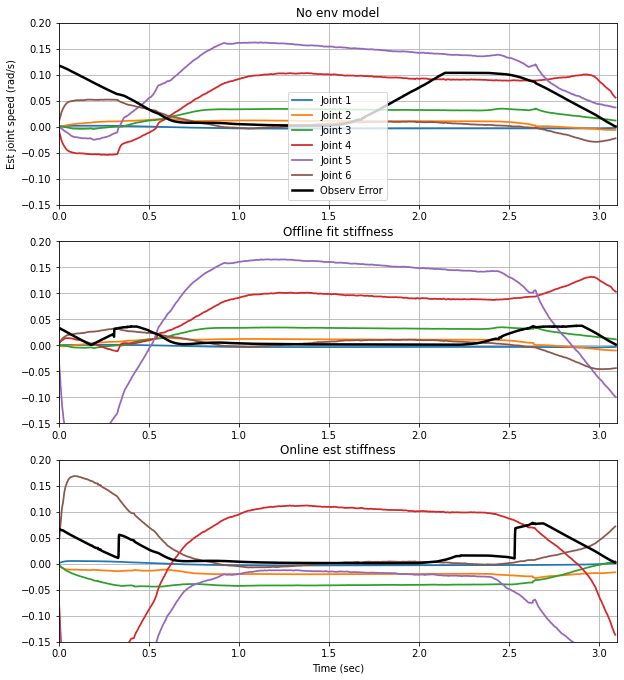

In [184]:
# Compare w/ and w/o stiffness model
bags = ['data/valid_contact_no_stiff.bag',
       'data/valid_contact_offline_stiff.bag',
       'data/valid_contact_online_stiff.bag']
names = ['No env model', 'Offline fit stiffness', 'Online est stiffness']

fig, axs = plt.subplots(3, figsize=(10,8))
cols = ['r', 'b', 'k', 'r:', 'b:', 'k:']
cm = plt.get_cmap('tab10')
for sp, (bag, name) in enumerate(zip(bags, names)):
    msgs = bag_loader(bag, map_joint_state, topic_name = 'joint_state')

    msgs2 = bag_loader(bag, map_joint_state, topic_name = 'observer_jt')
    q_hat = msgs2['pos']
    dq_hat = msgs2['vel']
    t_hat = msgs2['t']
    
    msgs = get_aligned_msgs(msgs2, msgs)
    print(msgs)
    q = msgs['pos']
    dq = msgs['vel']
    t = msgs['t']
    print(t)
    
    for ind in range(6):
        col = cm(ind)
        #axs[i].plot(t_hat, q_hat[ind,:], color = col, linestyle = 'dotted')
        #axs[1].plot(t, dq[ind,:], col)
        axs[sp].plot(t_hat, dq_hat[ind,:], color = col, linestyle = 'solid', label = 'Joint {}'.format(ind+1), linewidth=1.75)

    axs[sp].plot(t_hat, 10*np.linalg.norm(q-q_hat, axis=0), color = 'k', label = 'Observ Error', linewidth =2.5)

    axs[sp].set_title(name)

axs[0].legend(loc='lower center')
for i in range(3): axs[i].grid(True)
for i in range(3): axs[i].set_ylim((-0.15,0.2))
for i in range(3): axs[i].set_xlim((-0.0,3.1))
plt.xlabel('Time (sec)')
axs[0].set(ylabel='Est joint speed (rad/s)')
plt.subplots_adjust(top=1.2)
plt.savefig('joint_est_comp.pdf')
plt.show()

Loading ros bag data/valid_contact_online_stiff.bag  with 1397 msgs on topic /observer_jt
Loading ros bag data/valid_contact_online_stiff.bag  with 1248 msgs on topic /robot_state


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


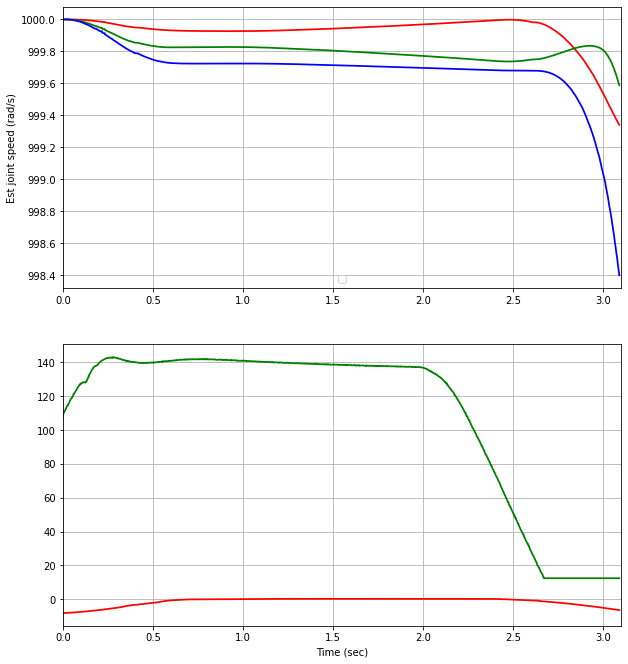

In [185]:
# Compare w/ and w/o stiffness model
bag = 'data/valid_contact_online_stiff.bag'

xrest = np.array(rospy.get_param('contact_1_rest'))
fig, axs = plt.subplots(2, figsize=(10,8))
cols = ['r', 'b', 'k', 'r:', 'b:', 'k:']
msgs2 = bag_loader(bag, map_joint_state, topic_name = 'observer_jt')
q_hat = msgs2['pos']
dq_hat = msgs2['vel']
stiff = msgs2['torque'][:3]
cont_pt = msgs2['torque'][3:]
t_hat = msgs2['t']

msgs = bag_loader(bag, map_robot_state, topic_name = 'robot_state')
msgs = get_aligned_msgs(msgs2, msgs)
q = msgs['pos']
dq = msgs['vel']
force = msgs['force']
t = msgs['t']


axs[0].plot(t_hat, stiff[0,:], color = 'r', linestyle = 'solid', linewidth=1.75)
axs[0].plot(t_hat, stiff[1,:], color = 'g', linestyle = 'solid', linewidth=1.75)
axs[0].plot(t_hat, stiff[2,:], color = 'b', linestyle = 'solid', linewidth=1.75)

disp = xrest-cont_pt
f = stiff.T@disp

axs[1].plot(t_hat, f[0,:], color = 'r', linestyle = 'solid', linewidth=1.75)
axs[1].plot(t_hat, force[2,:], color = 'g', linestyle = 'solid', linewidth=1.75)

axs[0].legend(loc='lower center')
for i in range(2): axs[i].grid(True)
for i in range(2): axs[i].set_xlim((-0.0,3.1))
plt.xlabel('Time (sec)')
axs[0].set(ylabel='Est joint speed (rad/s)')
plt.subplots_adjust(top=1.2)
plt.savefig('joint_est_comp.pdf')
plt.show()

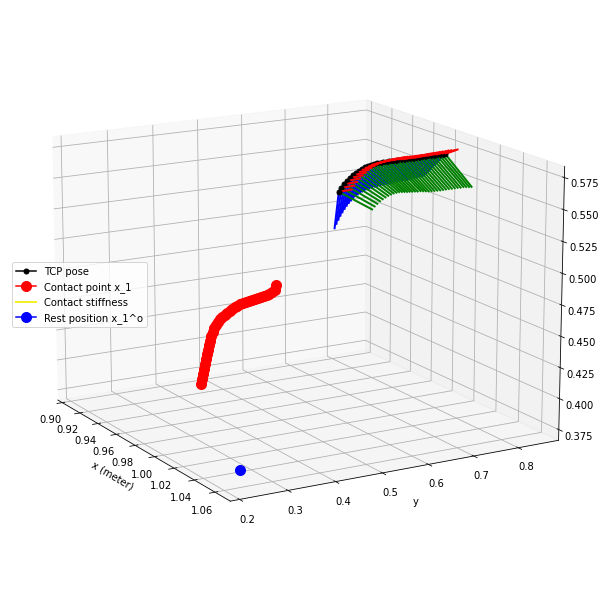

In [187]:
# Plotting the positoin and orientation of the robot and the estimated contact point
import pickle
#%matplotlib
#traj = 'data/racer_rotate_long_4.pkl'
traj = 'data/racer_rotate_and_slip_long_1.pkl'

rest_pos = rospy.get_param('contact_1_rest', [0.0, 0.0, 0.0]) 
#stiff = rospy.get_param('contact_1_stiff', [0.0, 0.0, 0.0]) 
scale = 0.03
scales = 5e-3#3e-6

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection="3d")
with open(traj, 'rb') as f:
    _, _, x_is, x_ees, stiffs = pickle.load(f)

num_pts = x_is.shape[1]
pos_last = x_ees[0][0]
min_dist = 0.008
cmap = plt.get_cmap('plasma')
for i, (xi, xee, stiff) in enumerate(zip(x_is.T, x_ees, stiffs.T)):
    p = np.array(xee[0]).flatten()
    o = np.array(xee[1])
    if np.linalg.norm(p[:3] - pos_last[:3]) < min_dist:
        continue
    else:
        pos_last = p
    x = np.array(o[0,:])
    y = np.array(o[1,:])
    z = np.array(o[2,:])
    xs = o@stiff
    
    ax.plot([p[0], p[0]+scale*x[0]],
            [p[1], p[1]+scale*x[1]],
            [p[2], p[2]+scale*x[2]],
            'r', linewidth=2)
    ax.plot([p[0], p[0]+scale*y[0]],
            [p[1], p[1]+scale*y[1]],
            [p[2], p[2]+scale*y[2]],
            'g', linewidth=2)
    ax.plot([p[0], p[0]+scale*z[0]],
            [p[1], p[1]+scale*z[1]],
            [p[2], p[2]+scale*z[2]],
            'b', linewidth=2)
    h_cs = ax.plot([xi[0], xi[0]-scales*xs[0]],
            [xi[1], xi[1]-scales*xs[1]],
            [xi[2], xi[2]-scales*xs[2]],
            color = cmap(float(i)/num_pts), linewidth=2)[0]
    h_ee = ax.plot(p[0], p[1], p[2], c = 'k', marker = 'o', ms = 5, label='TCP')[0]
    
    h_c1 = ax.plot(xi[0], xi[1], xi[2], c = 'r', marker = 'o', ms = 10, label='Estimated contact')[0]
h_rp1 = ax.plot(rest_pos[0], rest_pos[1], rest_pos[2], c= 'b',  marker = 'o', ms = 10, label='Estimated rest position')[0]
plt.tight_layout()
plt.xlabel('x (meter)')
plt.ylabel('y')
ax.view_init(elev=15., azim=-30.)
plt.legend(handles=[h_ee, h_c1, h_cs, h_rp1],labels=['TCP pose', 'Contact point x_1', 'Contact stiffness', 'Rest position x_1^o'], loc='center left')
plt.subplots_adjust(left=-0.11, right=1.11, bottom=0.0, top=1)
plt.savefig('online_stiff_long.pdf')
plt.show()

In [186]:
# Plotting the positoin and orientation of the robot and the estimated contact point
import pickle
#%matplotlib
traj = 'data/racer_rotate_long_4.pkl'
#traj = 'data/racer_rotate_and_slip_long_1.pkl'


fig = plt.figure(figsize=(8,8))
with open(traj, 'rb') as f:
    _, _, x_is, x_ees, stiffs = pickle.load(f)
stiffs = np.array(stiffs)
num_pts = x_is.shape[1]
print(stiffs)
ax.plot(stiffs[1,:])
plt.tight_layout()
plt.xlabel('x (meter)')
plt.ylabel('y')
#plt.savefig('offline_long_slip.pdf')
plt.show()

[[ 1.          1.          1.         ...  4.35273705  4.35415269
   4.35557356]
 [ 1.          1.          1.         ... -6.12331261 -6.12607878
  -6.12884532]
 [ 1.          1.          1.         ... -1.6001648  -1.60093416
  -1.60170439]]


TypeError: plot() missing 1 required positional argument: 'ys'

<Figure size 576x576 with 0 Axes>